In [40]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.metrics import f1_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.pyplot as plt
import math as m
from matplotlib import collections as mc

#### Edit Distance

In [20]:
def preprop(df):
    scaler = MinMaxScaler()
    #df[["datetime"]] = scaler.fit_transform(df[["datetime"]])
    df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
    return(df)

def createtraj(data, size):
    data["datetime"] = pd.to_datetime(data["datetime"])
    data["datetime"] = data["datetime"].apply(lambda v: v.timestamp())
    unpro = data.drop(["id"], axis = 1)
    unpro = unpro.values.tolist()
    preprodata = preprop(data)
    preprodata = preprodata.values.tolist()
    i = 0
    n = len(data)
    preprotraj = []
    traj =[]
    while i + size <= n:
        #print(data.iloc[i:i+size,:])
        traj.append(unpro[i:i+size])
        preprotraj.append(preprodata[i:i+size])
        i += size
    pptraj = [[i for i in n if np.isnan(i).any() == False] for n in preprotraj]
    trajn = [[i for i in n if np.isnan(i).any() == False] for n in traj]
    
    return (np.asarray(pptraj), np.asarray(trajn))

# Cost of deleting a point
def costdel(t, k, c):
    # Get all x, y, and time terms not in point
    x = np.array([t[i][2] for i in range(len(t)) if i != k])
    y = np.array([t[i][3] for i in range(len(t)) if i != k])
    ti = np.array([t[i][1] for i in range(len(t)) if i != k])
    n = len(t)

    # Calculate cost of displacement from deletion
    xpart = (((np.sum(x) + t[k][2]) / n) - (np.sum(x) / (n - 1))) ** 2
    ypart = (((np.sum(y) + t[k][3]) / n) - (np.sum(y) / (n - 1))) ** 2
    tpart = (((np.sum(ti) + t[k][1]) / n) - (np.sum(ti) / (n - 1))) ** 2
    cost = (1 - c) * (xpart + ypart) + c * (tpart)
    #     print("costdel xpart: ", xpart)
    #     print("costdel ypart: ", ypart)
    #     print("costdel tpart: ", tpart)
    #     print("costdel: ", cost)
    # Return cost
    return (m.sqrt(cost))

def costins(t, p, c):
    # Get all x, y, and time terms in the trajectory
    x = np.array([t[i][2] for i in range(len(t))])
    y = np.array([t[i][3] for i in range(len(t))])
    ti = np.array([t[i][1] for i in range(len(t))])
    n = len(t)

    # Calculate cost of insertion
    xpart = (((np.sum(x)) / n) - ((np.sum(x) + p[2]) / (n + 1))) ** 2
    ypart = ((np.sum(y) / n) - ((np.sum(y) + p[3]) / (n + 1))) ** 2
    tpart = ((np.sum(ti) / n) - ((np.sum(ti) + p[1]) / (n + 1))) ** 2
    cost = (1 - c) * (xpart + ypart) + c * (tpart)
    #     print("costins xpart: ", xpart)
    #     print("costins ypart: ", ypart)
    #     print("costins tpart: ", tpart)
    #     print("costins: ", cost)
    # Return cost
    return (m.sqrt(cost))

def costrep(t, k, p, c):
    # Get all x, y, and time terms not in point to be replaced
    x = np.array([t[i][2] for i in range(len(t)) if i != k])
    y = np.array([t[i][3] for i in range(len(t)) if i != k])
    ti = np.array([t[i][1] for i in range(len(t)) if i != k])
    n = len(t)

    # Calculate cost of displacement from replacement
    xpart = (((np.sum(x) + t[k][2]) / n) - ((np.sum(x) + p[2]) / n)) ** 2
    ypart = (((np.sum(y) + t[k][3]) / n) - ((np.sum(y) + p[3]) / n)) ** 2
    tpart = (((np.sum(ti) + t[k][1]) / n) - ((np.sum(ti) + p[1]) / n)) ** 2
    cost = (1 - c) * (xpart + ypart) + (c * tpart)
    #     print("costrep xpart: ", xpart)
    #     print("costrep ypart: ", ypart)
    #     print("costrep tpart: ", tpart)
    #     print("costrep: ", cost)
    # Return cost
    return (m.sqrt(cost))


# t's are formatted as [[id,x,y,time],[id,x,y,time],....] where time is pandas datetime
def editdist(t1, t2, c):
    # Revised trajectories
    # t1 = removered(t1)
    # t2 = removered(t2)
    
    t1 = np.asarray(t1)
    t2 = np.asarray(t2)
    # Get trajectory lengths
    n1 = len(t1)
    n2 = len(t2)
    #     print("n1: ", n1)
    #     print("n2: ", n2)

    # Create table to save prior solutions
    table = [[0 for i in range(n2 + 1)] for j in range(n1 + 1)]

    # Note, should t1 be updated before calculating cost of next insert/del?
    # Fill in table where i represents number of points in t1 and j the number of points in t2
    for i in range(n1 + 1):
        for j in range(n2 + 1):

            # Fill first row of table
            if i == 0:
                table[i][j] = sum([costins(t1, p, c) for p in t2[:j]])
            #                 print("table value with i = " +str(i) + "and j = " + str(j) + " : ", table[i][j])
            # Fill first column of table
            elif j == 0:
                table[i][j] = sum([costdel(t1, k, c) for k in range(i)])
            #                 print("table value with i = " +str(i) + "and j = " + str(j) + " : ", table[i][j])

            # Keep cost the same if points are the same
            elif t1[i - 1].all == t2[j - 1].all:
                table[i][j] = table[i - 1][j - 1]
            #                 print("table value with i = " +str(i) + "and j = " + str(j) + " : ", table[i][j])

            # Calculate whether insertion, deletion, or replacement costs the most, and save whichever one is least expensive
            else:
                valins = table[i][j - 1] + costins(t1, t2[j - 1], c)
                valdel = table[i - 1][j] + costdel(t1, i - 1, c)
                valrep = table[i - 1][j - 1] + costrep(t1, i - 1, t2[j - 1], c)
                #                 print("valins: ", valins)
                #                 print("valdel: ", valdel)
                #                 print("valrep: ", valrep)

                if (valins <= valdel) and (valins <= valrep):
                    table[i][j] = valins
                #                     print("valins in if: ", valins)
                #                     print("table value with i = " +str(i) + "and j = " + str(j) + " : ", table[i][j])

                elif (valdel <= valins) and (valdel <= valrep):
                    table[i][j] = valdel
                #                     print("valdel in if: ", valdel)
                #                     print("table value with i = " +str(i) + "and j = " + str(j) + " : ", table[i][j])

                elif (valrep <= valdel) and (valrep <= valins):
                    table[i][j] = valrep
    #                     print("valrep in if: ", valrep)
    #                     print("table value with i = " +str(i) + "and j = " + str(j) + " : ", table[i][j])

    return table[n1][n2]

#### Clustering Trajectories With Distance Matrix

In [21]:
def tclusteredit(lines, eps, minlns, distances):
    # Create array to hold cluster values
    Cluster = np.zeros(len(lines))
    # Set fist cluster to one
    cid = 1
    # For each trajectory
    for i in range(len(lines)):
        # if the trajectory is unclassified, classify it or designate it as noise
        if Cluster[i] == 0:
            # Get neighbors of a trajectory
            N = neighbor(i, eps, distances)
            # Check if trajectory has minimum number of neighbors
            if (len(N) >= minlns):
                # Give neighbors the cluster id
                for n in N:
                    Cluster[n] = cid
                queue = [n for n in N if n != i]
                # Expand cluster based on neighbors of neighbor
                Cluster = expandcluster(queue, cid, eps, minlns, Cluster, distances)
                # Move to next cluster
                cid += 1
            # If line is unclassified and without enough neighbors to be it's own cluster designate it as noise
            else:
                Cluster[i] = -1
    # Return list of cluster designations, with indices corresponding to trajectories' indices in lines array
    return Cluster

# Expland cluster based on neighbors of neighbor
def expandcluster(Q, cid, eps, minlns, Cluster, distances):
    while len(Q) != 0:
        M = Q.pop(0)
        N = neighbor(M, eps, distances)
        if (len(N) >= minlns):
            for n in N:
                if Cluster[n] in [0, -1]:
                    if Cluster[n] == 0:
                        Q.append(n)
                    Cluster[n] = cid
        return Cluster

# Get trajectory neighbor
def neighbor(i, eps, distances):
    neighbor_indices = np.where(distances[i] <= eps)[0]
    neighbor_indices = neighbor_indices[~np.isin(neighbor_indices, [i])]
    return neighbor_indices

#### Visualization Function

In [22]:
def visclust3D(lines, clusters, title, noise=True):
    # Create plot
    # fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')
    # Get number of clusters
    nclust = np.unique(clusters)

    # For each cluster
    for n in nclust:
        # Don't graph noise if specified not to
        if (noise == False and n == -1):
            continue
        # Get lines that are part of that cluster
        lines_index = lines[np.nonzero(clusters == n)]
        # hours_index = hours[np.nonzero(clusters==n)]

        # Format lines into lists of tuples of points
        linesplt = []
        for traj in lines_index:
            singleline = []
            for point in traj:
                singleline.append(tuple([point[1], point[2], point[0]]))
            linesplt.append(singleline)

        # plot points in cluster
        x = [i[0] for j in linesplt for i in j]
        y = [i[1] for j in linesplt for i in j]
        z = [i[2] for j in linesplt for i in j]
        p = ax.scatter3D(x, y, z, s=10, label="cluster " + str(n))

        # Get color of points
        color = p.get_facecolor()
        # Create and plot all lines in cluster
        lc = Line3DCollection(linesplt, linewidths=2, color=color)
        ax.add_collection3d(lc)

    # Set labels and display plot
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Time")
    plt.legend()
    plt.show()

In [46]:
def visclust(lines, clusters, noise = True):
    #Create plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    #Get number of clusters
    nclust = np.unique(clusters)

    #For each cluster
    for n in nclust:
        #Don't graph noise if specified not to
        if (noise == False and n == -1):
            continue
        #Get lines that are part of that cluster
        lines_index = lines[np.nonzero(clusters == n)]

        #Format lines into lists of tuples of points
        linesplt = []
        for traj in lines_index:
            singleline = []
            for point in traj:
                singleline.append(tuple([point[1], point[2], point[0]]))
            linesplt.append(singleline)

        # plot points in cluster
        x = [i[0] for j in linesplt for i in j]
        y = [i[1] for j in linesplt for i in j]
        z = [i[2] for j in linesplt for i in j]
        p = ax.scatter(y, z, s=10, label="cluster " + str(n))

        #Get color of points
        color = p.get_facecolor()

        #Create and plot all lines in cluster
        lc = mc.LineCollection(linesplt, linewidths=2, color=color)
        ax.add_collection(lc)

    #Set labels and display plot
    #ax.set_title("Taxi Trajectories Clustered by Trajectory")
    #ax.set_xlabel("Longitude")
    #ax.set_ylabel("Latitude")
    plt.legend()
    plt.show()

#### Get and Format STData

In [24]:
df1 = pd.read_csv("STData.csv")
df2 = pd.read_csv("STData_1.csv")

In [25]:
groupped = df1.groupby("id")

In [26]:
print(groupped.ngroups)

100


In [27]:
df1 = df1.replace([np.inf, -np.inf], np.nan)
df2 = df2.replace([np.inf, -np.inf], np.nan)

In [28]:
df1 = df1.rename(columns={'Time': 'datetime'})
df2 = df2.rename(columns={'Time': 'datetime'})

In [29]:
cols = ["id", "datetime","X", "Y"]
df3 = df1[cols]
df4 = df2[cols]

In [30]:
clust1, vis1 = createtraj(df3,50)
clust2, vis2 = createtraj(df4,50)

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

#### Get Distance Matrices

In [31]:
distances1 = np.genfromtxt('STDataDistances.csv', delimiter=',')

In [32]:
print(distances1)

[[0.         0.20562654 0.11180741 ... 0.02485843 0.22303195 0.26427189]
 [0.22161998 0.         0.14756914 ... 0.21948691 0.04070481 0.30130339]
 [0.1130076  0.136877   0.         ... 0.10950254 0.15866755 0.26539333]
 ...
 [0.02475272 0.20414735 0.1068861  ... 0.         0.22251035 0.26494496]
 [0.23410679 0.03986322 0.16347702 ... 0.23252514 0.         0.30656397]
 [0.25964064 0.2796611  0.25942476 ... 0.26043568 0.28626741 0.        ]]


In [33]:
distances2 = np.genfromtxt('STData1Distances.csv', delimiter=',')

#### Cluster

In [34]:
clusters1 = tclusteredit(clust1, 0.05, 5, distances1)
print(clusters1)

[1. 2. 3. 1. 2. 2. 2. 2. 3. 3. 4. 2. 1. 3. 5. 3. 5. 2. 3. 2. 3. 5. 4. 3.
 3. 3. 5. 5. 3. 2. 3. 3. 5. 2. 3. 3. 3. 5. 2. 3. 2. 3. 3. 2. 3. 3. 2. 5.
 3. 3. 3. 4. 3. 3. 2. 2. 3. 5. 2. 3. 2. 3. 5. 1. 3. 4. 4. 2. 2. 2. 1. 4.
 2. 3. 3. 5. 1. 2. 3. 3. 2. 1. 2. 2. 3. 1. 3. 3. 2. 5. 1. 2. 3. 5. 3. 4.
 5. 1. 2. 5.]


In [35]:
clusters2 = tclusteredit(clust2, 0.15, 5, distances2)
print(clusters2)

[ 1.  1.  2.  1.  1.  3.  3.  2.  3.  3.  1.  1.  3.  3.  1.  3. -1.  1.
  1.  1.  3.  1.  1.  1.  1.  1.  2.  3.  1.  1.  3.  1.  1.  3.  3.  3.
  1.  1.  1.  1.  1.  2. -1.  1.  2.  1.  2.  3.  3.  3.  1.  1.  1.  2.
  1.  1.  3.  1.  1.  1.  1.  1.  1.  1.  1.  3.  2.  1.  1.  2.  1.  1.
  1.  1.  1.  1.  2.  3.  1.  1.  3.  1.  1.  1.  1.  2.  1.  1.  1.  3.
  2.  1.  1.  1.  1.  1.  1.  1.  1.  3.]


#### Visualize

In [50]:
def plot_clusters(data, labels, cluster, ax = None):
    ax = ax
    groupedpp = data.groupby("id")
    index = np.arange(groupedpp.ngroups)
    for i, df in zip(index, groupedpp):
        if labels[i] == cluster:
            ax.plot(df[1]["X"], df[1]["Y"])
    return ax

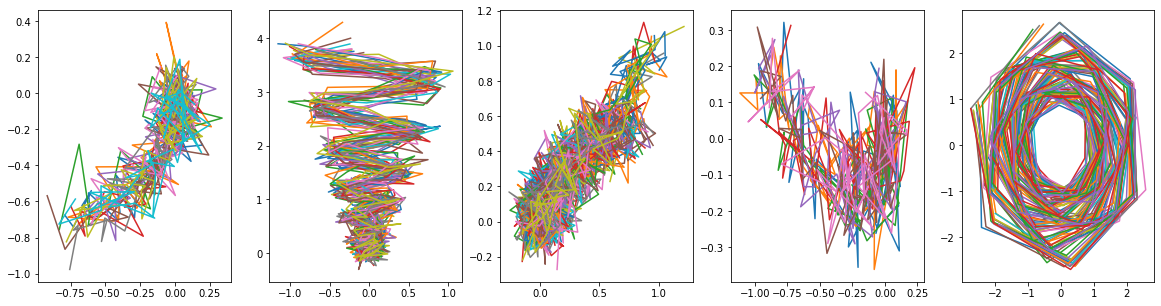

In [53]:
fig, ax = plt.subplots(1,5, figsize = (20, 5))
for i in range(5):
    plot_clusters(df1, clusters1, i+1, ax[i])
plt.tight_layout
plt.show()

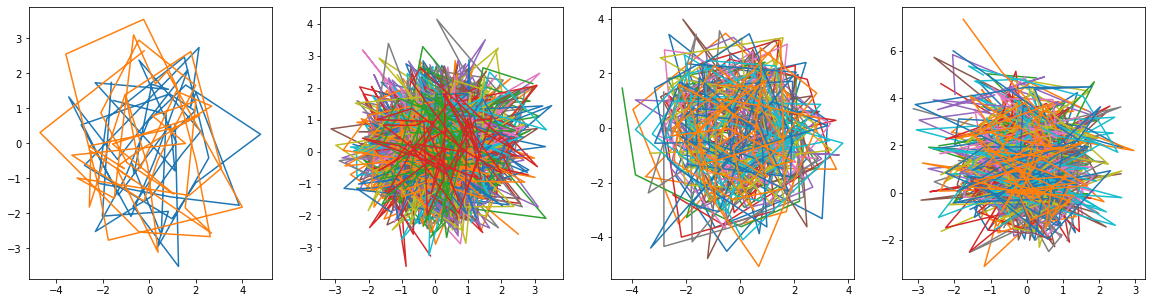

In [57]:
fig, ax = plt.subplots(1,4, figsize = (20, 5))
clusterlabels = [-1, 1, 2, 3, 4]
for i in range(4):
    plot_clusters(df2, clusters2, clusterlabels[i], ax[i])
plt.tight_layout
plt.show()

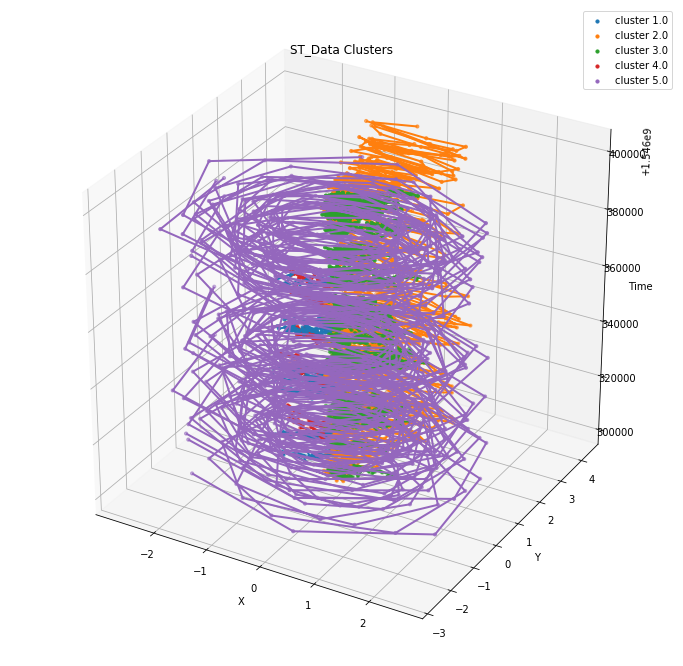

In [37]:
visclust3D(vis1, clusters1, "ST_Data Clusters")

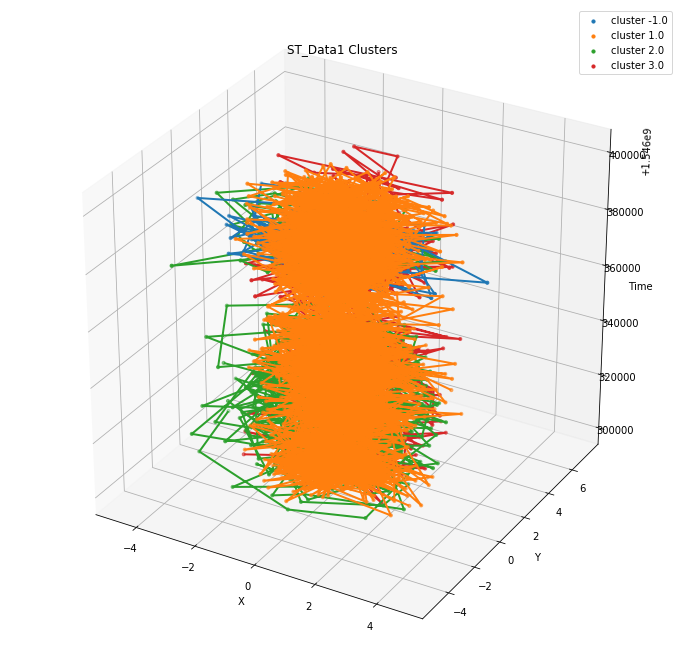

In [38]:
visclust3D(vis2, clusters2, "ST_Data1 Clusters")

#### Get Silhouette Scores

In [16]:
#Create silhouette function that doesn't count noise toward the value total
def silhouettenoise(distances, clusters):
    uniqueclust, counts = np.unique(clusters, return_counts = True)
    ndict = dict(zip(uniqueclust, counts))
    uniqueclust = uniqueclust[~np.isin(uniqueclust, [-1])]
    new_dict = {new_list: [] for new_list in range(4)}
    s = {u:[] for u in uniqueclust}
    stot = []
    for i in range(100):
        a = 0
        bmin = m.inf
        cluster = clusters[i]
        
        #ignore noise cluster
        if cluster == -1:
            continue
         
        for j in range(100):
            if i != j:
                if cluster == clusters[j]:
                    a += distances[i][j]   
        a = a * (1/(ndict[cluster]-1))

        for c in uniqueclust:
            b = 0
            k = 0
            if c != cluster:
                for j in range(100):
                    if i != j:
                        if c == clusters[j]:
                            k += 1
                            b += distances[i][j]
                b = b * (1/ndict[c])
            if b < bmin and k != 0:
                bmin = b
   
        if a < bmin:
            x = 1 - (a/bmin)
            s[cluster].append(x)
            stot.append(x)
        if a == bmin:
            print(0)
            s[cluster].append(0)
            stot.append(0)
        if a > bmin:
            x = (bmin/a) - 1
            s[cluster].append(x)
            stot.append(x)
    return np.mean(stot)
            

In [17]:
print(type(clusters1))

<class 'numpy.ndarray'>


In [18]:
silhouette1 = silhouette_score(distances1, clusters1, metric = "precomputed")
print(silhouette1)

0.712181672336589


In [19]:
silhouette2 = silhouette_score(distances2, clusters2, metric = "precomputed")
print(silhouette2)

0.15673664508385513


In [20]:
silhouette2n = silhouettenoise(distances2, clusters2)
print(silhouette2n)

0.16416389282716787


#### Function to get relationship between trajectories and clusters for F1 Score

In [21]:
#df has a row for each traj, with two columns id and cluster
#returns an list with 0 if the two are in different clusters and 1 if they are in the same cluster
def get_truthclust(df):
    #Create list to hold truth labels
    truthlabel = []
    #iterate through trajectories
    for i in range(len(df)):
        #iterate through trajectories so we look at unique combinations of trajectories
        for j in range(i,len(df)):
            #skip if the two trajectories are the same
            if i != j:
                #if the trajectories are in the same clusters save 1
                if df.iloc[i,1] == df.iloc[j,1]:
                    truthlabel.append(1)
                #if the trajectories are in different clusters save 0
                else:
                    truthlabel.append(0)
    return truthlabel

#### Get F1 Scores

In [22]:
df1gt = df1.groupby('id', as_index=False)[["group"]].first()
print(len(df1gt))
df1gt.head()

100


,id,group
0,0,parametric4
1,1,parametric3
2,2,parametric1
3,3,parametric4
4,4,parametric3


In [23]:
df2gt = df2.groupby('id', as_index=False)[["group"]].first()
print(len(df2gt))
df2gt.head()

100


,id,group
0,0,parametric5
1,1,parametric5
2,2,parametric2
3,3,parametric1
4,4,parametric4


In [24]:
vals = [i for i in range(100)]
df1cr = pd.DataFrame(list(zip(vals, clusters1)), columns = ["id", "group"])

In [25]:
df2cr = pd.DataFrame(list(zip(vals, clusters2)), columns = ["id", "group"])

In [26]:
gtlabels1 = get_truthclust(df1gt)
crlabels1 = get_truthclust(df1cr)
print(len(gtlabels1))
print(len(crlabels1))

4950
4950


In [27]:
f1score1 = f1_score(gtlabels1, crlabels1)
print(f1score1)

0.8075601374570446


In [28]:
gtlabels2 = get_truthclust(df2gt)
crlabels2 = get_truthclust(df2cr)
print(len(gtlabels2))
print(len(crlabels2))

4950
4950


In [29]:
f1score2 = f1_score(gtlabels2, crlabels2)
print(f1score2)

0.5805498078628437


In [30]:
from sklearn.metrics import fowlkes_mallows_score

In [44]:
groundtruth1 = df1.groupby('id', as_index=False)[["group"]].first().drop("id", axis = 1).values.reshape(100,)
groundtruth2 = df2.groupby('id', as_index=False)[["group"]].first().drop("id", axis = 1).values.reshape(100,)

In [45]:
print(fowlkes_mallows_score(groundtruth1, clusters1))
print(fowlkes_mallows_score(groundtruth2, clusters2))

0.814722033436376
0.6243684619191735
